The following is the notebook of code written by H. Passmore for the assessment and tuning of Machine Learning algorithms for Capstone 1: Amazon Book Reviews & Ratings Predictor. 

# Machine Learning Algorithms for Capstone 1
_Amazon Book Reviews & Ratings Predictor_

_Machine Learning Code_
***

### Below is the code for assessing and tuning machine learning algorithms to predict ratings from reviews.

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import numpy as np
import scipy as sp

# Build figures inline
%matplotlib inline

In [2]:
# Setup Pandas  
pd.set_option('display.width', 350)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

# import Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

# import SVM classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Import Pipeline 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [4]:
# Implement tools to Reduce Document Dimensions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem.snowball import SnowballStemmer
import string

In [5]:
# set 'SW' as english stopwords from NLTK and count them
SW = set(stopwords.words('english'))
print('Number of english stopwords', len(SW))

Number of english stopwords 179


In [6]:
# view english stopwords
print(SW)

{'myself', 'here', 'mustn', "didn't", 'our', 'her', 'his', 'wasn', 'just', 'an', 'on', "that'll", 'after', 'as', 'has', 'against', 'been', 'ma', 'am', "isn't", 'i', 'out', "wouldn't", 've', 'me', 'about', 'with', 'that', 'over', 'its', 'each', 'at', 'only', "wasn't", 'ourselves', 'what', 'which', "shouldn't", "won't", 'nor', 'shan', 'off', "mustn't", 'who', 'until', 'most', "hasn't", "you'd", 'then', 'this', 'had', 'up', 'now', 'your', 'for', 'of', 'by', 'it', 'from', 'm', 'being', 'did', 'how', 'isn', 'but', 'very', "you're", 'needn', 'no', 'doing', 'ain', 'they', "couldn't", 'why', 'doesn', 'she', 'or', 'ours', 'any', 'haven', 'is', 'before', 'under', 'do', 'weren', 'where', "aren't", 'further', "don't", 'we', "she's", "you'll", 'in', 'yours', 'mightn', 'whom', 'my', 'was', 'above', 'other', 'to', 'so', "needn't", "shan't", 'yourselves', 'below', 'itself', 'their', 'he', "mightn't", 'does', 'some', 'theirs', 'won', "haven't", 'herself', 'down', 'shouldn', 'yourself', 'there', 'hasn',

In [7]:
# remove 'not' from set SW
SW.remove('not')
# other negation words in stopwords set: "shouldn't",'haven',"wasn't",'wasn', "don't",'hasn', "mightn't",
#'didn',"n't", 'couldn',"won't","couldn't", 'weren',"hasn't",'don','not', "weren't","wouldn't","hadn't",
#'mustn','wouldn',"haven't"
print('Reduced number of stopwords', len(SW))

Reduced number of stopwords 178


In [8]:
# bring the book_revs dataframe into workspace from the inferential statistics code
# load the pickled  DataFrame of Science Textbook Reviews from hard drive in 'rb' mode
import pickle
with open('book_revs_forML.pickle','rb') as f:
    book_revs = pickle.load(f)

### Check dataframe of ratings and review text

In [9]:
# check input data for Machine Learning: reviewText and rating_cat
book_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11546 entries, 0 to 11545
Data columns (total 9 columns):
asin           11546 non-null object
overall        11546 non-null int64
reviewText     11546 non-null object
summary        11546 non-null object
five_not5      11546 non-null object
rating_cat     11546 non-null int64
token_count    11546 non-null int64
caps_count     11546 non-null int64
pct_caps       11546 non-null float64
dtypes: float64(1), int64(4), object(4)
memory usage: 811.9+ KB


In [10]:
# keep only what we need
# rating_cat: '0' =  'low' rating, '1' = 'high' rating
rev_rate = book_revs.drop(['asin', 'overall', 'summary', 'five_not5', 'token_count', 'caps_count', 'pct_caps'], axis=1)
rev_rate.head(2)

,reviewText,rating_cat
0,This is a good book for the science nerd and t...,0
1,"If you're a biology/genetics enthusiast, this ...",1


## Preprocess review text to reduce document dimensions

In [11]:
# combine my review-specific stopwords with english stopwords (minus 'not') as a set
user_defined_stop_words = ['book', 'books']

i = SW
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

In [12]:
# print the combined list of stopwords and punctuation
print(stopwords)

{'here', '~', "didn't", 'our', 'his', 'wasn', 'just', 'after', 'as', 'has', 'been', 'am', "isn't", 'i', '\\', '^', "wouldn't", 've', '-', '*', 'with', '%', "won't", 'which', "shouldn't", 'nor', 'shan', 'off', "you'd", 'had', 'your', 'for', 'of', 'by', 'from', 'did', 'how', 'but', "you're", 'doing', 'they', "couldn't", 'she', 'or', 'ours', 'haven', 'is', 'do', 'weren', 'where', "she's", "you'll", '{', 'was', '=', '`', 'books', 'so', "needn't", "shan't", '?', 'itself', 'their', 'he', "mightn't", 'does', '>', 'theirs', 'won', "haven't", 'herself', 'down', 'shouldn', 'yourself', 'hasn', 'the', 'once', 'into', 'don', 't', 'again', 'because', 'them', '.', 'o', 'didn', 'should', 'while', 'can', 'book', 'both', 'own', 's', ')', '_', '+', 'and', 'wouldn', '(', ':', '"', 'a', 'couldn', 'these', 'all', 'same', 'those', ',', 'myself', 'mustn', 'her', 'an', 'on', "that'll", 'against', 'ma', '#', 'out', 'me', 'about', 'that', 'over', 'its', 'each', 'at', 'only', "wasn't", 'ourselves', 'what', "mustn

In [13]:
# define first preprocessor
def preprocess(x):
    letters_only = re.sub('[^a-zA-Z]', ' ', str(x))                  # keep alpha only
    words = letters_only.lower().split()                            # lowercase everything  
    useful_words = [w for w in words if w not in set(stopwords)]    # remove stopwords
    return (' '.join(useful_words))

In [14]:
# apply preprocessor to review text
rev_rate['clean_revs'] = rev_rate['reviewText'].apply(preprocess)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,definitely must read home cooking enthusiast w...
11542,Pros: Scientifically informative and solid. Kn...,0,pros scientifically informative solid knowing ...
11543,Real fun to read. For everybody that is inters...,0,real fun read everybody intersted cooking cert...
11544,This book will teach you the chemical secrets ...,0,teach chemical secrets techniques usually used...
11545,I paid more than $30 to buy such a superficial...,0,paid buy superficial trivial made big mistake ...


In [15]:
# instantiate the stemmer
stemmer = SnowballStemmer("english")

In [16]:
# define second preprocessor for tokenization and stemming
def preprocess2(text):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    tokens = word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [17]:
# apply second preprocessor to clean_revs
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(preprocess2)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,"[definit, must, read, home, cook, enthusiast, ..."
11542,Pros: Scientifically informative and solid. Kn...,0,"[pros, scientif, inform, solid, know, chemic, ..."
11543,Real fun to read. For everybody that is inters...,0,"[real, fun, read, everybodi, interst, cook, ce..."
11544,This book will teach you the chemical secrets ...,0,"[teach, chemic, secret, techniqu, usual, use, ..."
11545,I paid more than $30 to buy such a superficial...,0,"[paid, buy, superfici, trivial, made, big, mis..."


In [18]:
# clean_revs must be a list of strings for vectorization steps
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(str)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,"['definit', 'must', 'read', 'home', 'cook', 'e..."
11542,Pros: Scientifically informative and solid. Kn...,0,"['pros', 'scientif', 'inform', 'solid', 'know'..."
11543,Real fun to read. For everybody that is inters...,0,"['real', 'fun', 'read', 'everybodi', 'interst'..."
11544,This book will teach you the chemical secrets ...,0,"['teach', 'chemic', 'secret', 'techniqu', 'usu..."
11545,I paid more than $30 to buy such a superficial...,0,"['paid', 'buy', 'superfici', 'trivial', 'made'..."


In [19]:
rev_rate.clean_revs[-9:-1]

11537    ['author', 'good', 'job', 'describ', 'scientif...
11538    ['buy', 'look', 'cookbook', 'recip', 'list', '...
11539    ['receipt', 'perfect', 'excel', 'condit', 'con...
11540    ['fascin', 'explor', 'physic', 'cook', 'writte...
11541    ['definit', 'must', 'read', 'home', 'cook', 'e...
11542    ['pros', 'scientif', 'inform', 'solid', 'know'...
11543    ['real', 'fun', 'read', 'everybodi', 'interst'...
11544    ['teach', 'chemic', 'secret', 'techniqu', 'usu...
Name: clean_revs, dtype: object

## Create X & y, split train and test data sets

In [20]:
# store the feature matrix (X) and response vector (y) 
# uppercase X because it's an m x n matrix
X = rev_rate.clean_revs

# lowercase y because it's a m x 1 vector
y = rev_rate.rating_cat

print(X.shape)
print(y.shape)

(11546,)
(11546,)


In [21]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 8659
X Testing set sample size: 2887
y Training set sample size: 8659
y Testing set sample size: 2887


In [22]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.336412980714
0.336335296155


In [23]:
print(X_train[0:2])

7665    ['rainforest', 'grew', 'around', 'susan', 'k',...
1141    ['consequ', 'develop', 'electron', 'superintel...
Name: clean_revs, dtype: object


## Vectorize, fit, output document-term matrix with two vectorizers

In [24]:
# instantiate two vectorizers, do not use stop_words
vect = CountVectorizer(stop_words=None, lowercase=False, analyzer='word', tokenizer=None, min_df=3,ngram_range=(1, 2)) 
tfidf = TfidfVectorizer(stop_words=None, max_df=0.7, lowercase=False, min_df=3, ngram_range=(1, 2))

In [25]:
# Apply CountVectorizer ('vect') to stemmed tokens to learn training data vocabulary
# then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train.values)

# examine the document-term matrix
X_train_dtm

<8659x36938 sparse matrix of type '<class 'numpy.int64'>'
	with 595860 stored elements in Compressed Sparse Row format>

In [26]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test.values)
X_test_dtm

<2887x36938 sparse matrix of type '<class 'numpy.int64'>'
	with 184718 stored elements in Compressed Sparse Row format>

In [27]:
# Apply TfidfVectorizer to learn training data vocabulary
# then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train.values)

# examine the document-term matrix
X_train_tfidf

<8659x36938 sparse matrix of type '<class 'numpy.float64'>'
	with 595860 stored elements in Compressed Sparse Row format>

In [28]:
# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test.values)
X_test_tfidf

<2887x36938 sparse matrix of type '<class 'numpy.float64'>'
	with 184718 stored elements in Compressed Sparse Row format>

In [29]:
# view current parameters for CountVectorizer 'vect'
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [30]:
# view current parameters for TfidfVectorizer 'tfidf'
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.7, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Build the simple model with Naive Bayes for baseline and to compare vectorizers

In [31]:
# instantiate scikit-learn's MultinomialNB() classifier to use on CountVec vectors
nb = MultinomialNB(alpha=1, fit_prior=True)

In [32]:
# train the model using X_train_dtm from CountVectorizer (vect)
%time nb.fit(X_train_dtm, y_train)

CPU times: user 15.7 ms, sys: 14.6 ms, total: 30.3 ms
Wall time: 32.2 ms


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [33]:
# COMPARE TFIDF VECTORIZER
# instantiate scikit-learn's MultinomialNB() classifier to use on tfidf vectors
nbtfidf = MultinomialNB(alpha=1, fit_prior=True) 

In [34]:
# COMPARE TFIDF VECTORIZER
# train the model using X_train_tfidf from TfidfVectorizer
%time nbtfidf.fit(X_train_tfidf, y_train)

CPU times: user 14.2 ms, sys: 13.8 ms, total: 28 ms
Wall time: 25.9 ms


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [35]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_class) #score was up to .82 with 'not' removed but down again with min_df=3

0.81231380337636538

In [36]:
# COMPARE TFIDF VECTORIZER
# make class predictions for X_test_dtm
y_pred_tfidf = nbtfidf.predict(X_test_tfidf)

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_tfidf)

0.80633579725448778

In [37]:
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 495,  476],
       [ 280, 1636]])

Confusions Matrix breakdown for Count Vectorizer with Naive Bayes:
True Positives: 1636 reviews correctly predicted as 'five'
True Negatives: 495 reviews correctly predicted as 'not5'
False Positives: 476 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 280 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

In [38]:
# COMPARE TFIDF VECTORIZER
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_tfidf)

array([[  61,  910],
       [   7, 1909]])

Confusions Matrix breakdown for TFIDF Vectorizer with Naive Bayes:
True Positives: 1909 reviews correctly predicted as 'five'
True Negatives: 61 reviews correctly predicted as 'not5'
False Positives: 910 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 7 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

Before tuning Naive Bayes parameters with GridSearchCV (below) the TfidfVectorizer with default settings performs poorly assigning review text to high vs low rating categories.

In [39]:
# calculate predicted probabilities for X_test_dtm (document-term matrix from CountVectorizer)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.99457259,  0.91868987,  0.19803406, ...,  0.99995244,
        0.99908528,  0.99999971])

In [40]:
# COMPARE TFIDF VECTORIZER
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob_tfidf = nbtfidf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_tfidf

array([ 0.89208592,  0.85519454,  0.60892288, ...,  0.96112489,
        0.88263227,  0.92979038])

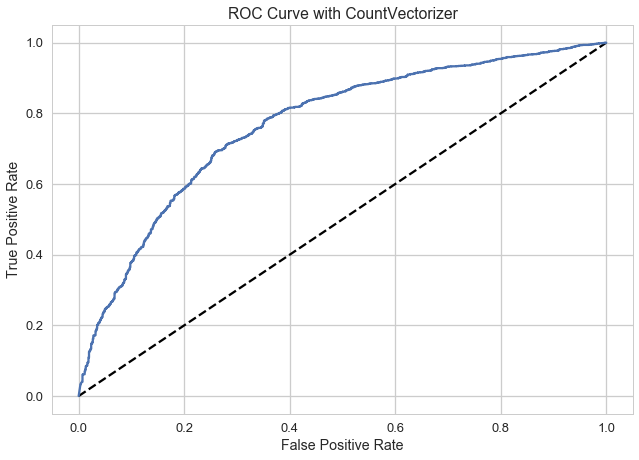

In [41]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve for Naive Bayes with CountVectorizer
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with CountVectorizer')
plt.show()

In [42]:
# calculate AUC for NB model with CountVect
metrics.roc_auc_score(y_test, y_pred_prob) # increasing min_df to 3 improved score

0.76802185079196494

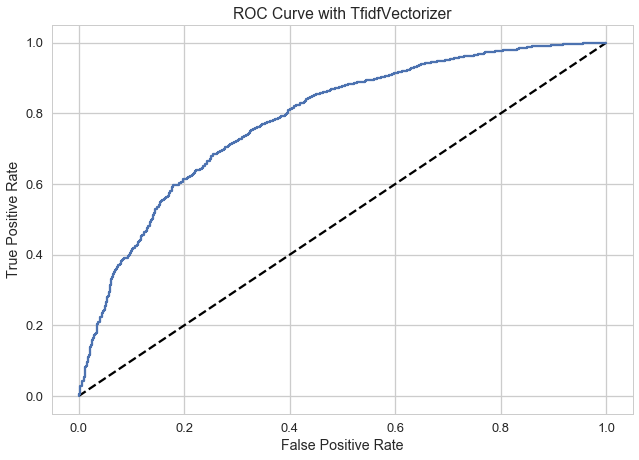

In [43]:
# COMPARE TFIDF VECTORIZER
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_tfidf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TfidfVectorizer')
plt.show()

In [44]:
# COMPARE TFIDF VECTORIZER
# calculate AUC for simple model
metrics.roc_auc_score(y_test, y_pred_prob_tfidf) # increasing min_df to 3 improved score

0.78286702686897047

### Run GridSearchCV on best parameters for CountVectorizer

In [45]:
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {'fit_prior': (True, False),
              #'class_prior': (True, False), 
              'alpha': (0.001, 0.1, 1, 5, 10)
             }

In [46]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [47]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_mnb = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1)
gs_mnb = gs_mnb.fit(X_train_dtm, y_train)

In [48]:
# View the best score (set to roc_auc) for MultinomialNB with CountVect
print('Best score for text:', gs_mnb.best_score_) 

Best score for text: 0.762436055907


In [49]:
# Get best parameters for MultinomialNB with CountVect
print('Best parameters:', gs_mnb.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default) 

Best parameters: {'alpha': 1, 'fit_prior': True}


In [50]:
# view parameters of grid search multinomial niave bayes model with countvectorizer
gs_mnb

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### Run GridSearchCV on best parameters for TfidfVectorizer

In [51]:
# fit grid search again with DTM for tfidf vectorizer (same parameters)
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1)
gs_tfidf = gs_tfidf.fit(X_train_tfidf, y_train)

In [52]:
# View the best score (set to roc_auc)
print('Best score for text:', gs_tfidf.best_score_) 

Best score for text: 0.777709617489


In [53]:
# Get best parameters
print('Best parameters:', gs_tfidf.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default)

Best parameters: {'alpha': 1, 'fit_prior': True}


In [54]:
# view parameters of grid search multinomial niave bayes model with tfidf vectorizer
gs_tfidf

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

__Interpretation of simple model:__ The Naive Bayes model trained on stemmed tokens with stop words removed performs fairly well. GridSearchCV indicates the best parameters for the two vectorizers are the default Multinomial Naive Bayes parameters. For the rest of the algorithms I will use the document terms matrix from the TfidfVectorizer based on the comparisons above.

## Examine model inputs for further insight

In [55]:
# store the vocabulary of X_train with CountVectorizer
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

36938

In [56]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['aa', 'aacut', 'aarhus', 'aarhus denmark', 'aaron', 'aaron sach', 'ab', 'abandon', 'abandon resort', 'abbrevi', 'abc', 'abid', 'abil', 'abil bring', 'abil convey', 'abil creat', 'abil explain', 'abil grow', 'abil learn', 'abil make', 'abil predict', 'abil read', 'abil speak', 'abil surviv', 'abil take', 'abil think', 'abil understand', 'abil write', 'abl', 'abl bring', 'abl buy', 'abl come', 'abl convey', 'abl easili', 'abl experi', 'abl explain', 'abl figur', 'abl find', 'abl finish', 'abl follow', 'abl get', 'abl go', 'abl grasp', 'abl identifi', 'abl keep', 'abl learn', 'abl look', 'abl make', 'abl navig', 'abl prove']


In [57]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['zero', 'zero babylonian', 'zero biographi', 'zero came', 'zero charl', 'zero concept', 'zero develop', 'zero histori', 'zero infin', 'zero infinit', 'zero interest', 'zero introduc', 'zero make', 'zero mathemat', 'zero not', 'zero number', 'zero one', 'zero point', 'zero quot', 'zero realli', 'zero riemann', 'zero seif', 'zero sort', 'zero star', 'zero start', 'zero use', 'zero vacuum', 'zero void', 'zero well', 'zero would', 'zero zero', 'zero zeta', 'zeta', 'zeta function', 'zodiac', 'zone', 'zone also', 'zone come', 'zone demon', 'zone one', 'zone read', 'zone terrifi', 'zoo', 'zoolog', 'zoologist', 'zoom', 'zoonos', 'zoonosi', 'zoonot', 'zoonot diseas']


In [58]:
# Examine features with largest and smallest coefficients from Tfidf/Multinomial NB model
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = nbtfidf.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['err' 'whatev problem' 'put writer' 'believ zero' 'follow fact'
 'follow first' 'loos leaf' 'loos end' 'loos connect' 'look went']

Largest Coefs: 
['read' 'love' 'great' 'not' 'one' 'year' 'inform' 'well' 'use' 'interest']



In [59]:
# test the current model
print(nbtfidf.predict(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[1 1]


In [60]:
# test the current model with more extreme review text
print(nbtfidf.predict(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[1 1]


In [62]:
# test test without 'not' bigrams
print(nbtfidf.predict(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[1 1]


The text reviews with negation phrases are both assigned to the 'high' rating category. The more extreme review text samples are also assigned to the 'high' category! The current model includes bigrams in the document-terms matrix and we removed 'not' from the list of stopwords. However, the Naive Bayes model does not assign 'not good' to the 'low' review class.

## Fit classifiers with TFIDF Vectorizer

## Fit Random Forest classifier

In [63]:
# classifier with grid search parameters (multiple runs to target best parameters)
rf_clf = RandomForestClassifier(max_features=700, min_samples_leaf=8, class_weight='balanced').fit(X_train_tfidf, y_train)
# parameters added after GridSearch below
predicted_rf_clf = rf_clf.predict(X_test_tfidf)

metrics.f1_score(y_test, predicted_rf_clf)

0.78563772775991436

In [64]:
# print the confusion matrix 
metrics.confusion_matrix(y_test, predicted_rf_clf)

array([[ 621,  350],
       [ 450, 1466]])

In [65]:
# calculate predicted probabilities
y_pred_prob_rf_clf = rf_clf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_rf_clf

array([ 0.67191513,  0.34039986,  0.2449276 , ...,  0.81926685,
        0.84946318,  0.74803912])

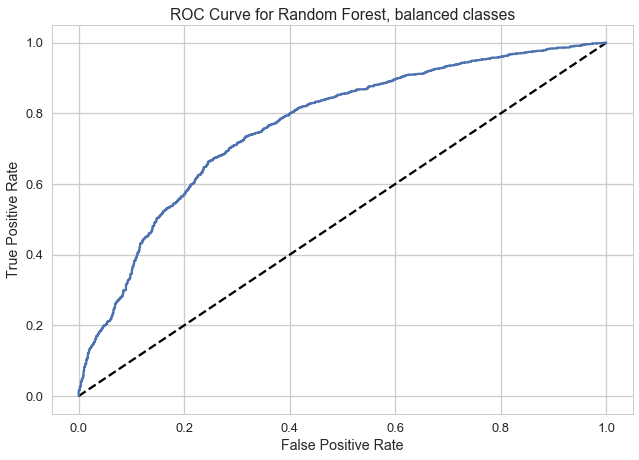

In [66]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf_clf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest, balanced classes')
plt.show()

In [67]:
# calculate AUC for randomforest model
metrics.roc_auc_score(y_test, y_pred_prob_rf_clf)

0.76279753778146631

In [68]:
# use to get a list of the all available pipe-items unique keys for the grid parameters
sorted(rf_clf.get_params().keys())

['bootstrap',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [69]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
params = {'max_features': [650, 700, 750],
              'min_samples_leaf': (5, 6, 7, 8),
              #'min_samples_split': (1, 3, 10),
              #'tfidf__use_idf': (True, False), 
              #'mnb__alpha': (0.1, 1, 5, 10)
         }

In [70]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train_tfidf, y_train) 

In [71]:
# View the best accuracy score
print('Best score for text:', gs_rf.best_score_) 
# prior run gave: Best score for text: 0.742

Best score for text: 0.75515200052


In [72]:
# Get best parameters
print('Best parameters:', gs_rf.best_params_)
# prior run gave: Best parameters: {'max_features': 700, 'min_samples_leaf': 5} 

Best parameters: {'max_features': 750, 'min_samples_leaf': 8}


In [73]:
# get array of Random Forest feature importances
rf_clf.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [74]:
import eli5
eli5.show_weights(rf_clf, vec=tfidf, top=20, target_names=y_test)

Weight,Feature
0.0423 ± 0.0431,love
0.0418 ± 0.0344,not
0.0223 ± 0.0204,good
0.0214 ± 0.0272,great
0.0167 ± 0.0223,would
0.0160 ± 0.0240,howev
0.0125 ± 0.0190,wonder
0.0121 ± 0.0202,excel
0.0119 ± 0.0271,disappoint
0.0119 ± 0.0252,much


In [75]:
# test the current model
print(rf_clf.predict(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[0 0]


In [76]:
# test the current model with more extreme review text
print(rf_clf.predict(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[0 1]


In [77]:
# test test without 'not' bigrams
print(rf_clf.predict(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[0 0]


## Fit LogisticRegressionCV classifier

In [78]:
# Logistic Regression CV classifier.
logreg_clf = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced').fit(X_train_tfidf, y_train)

predicted_logreg_clf = logreg_clf.predict(X_test_tfidf)

metrics.f1_score(y_test, predicted_logreg_clf)

0.81567796610169496

In [79]:
# print the confusion matrix 
metrics.confusion_matrix(y_test, predicted_logreg_clf)

array([[ 651,  320],
       [ 376, 1540]])

In [80]:
# calculate predicted probabilities for X_test with stemmed Logistic Regression model
y_pred_prob_logreg_clf = logreg_clf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_logreg_clf

array([ 0.82249922,  0.65528285,  0.17260319, ...,  0.90989356,
        0.91937177,  0.90839186])

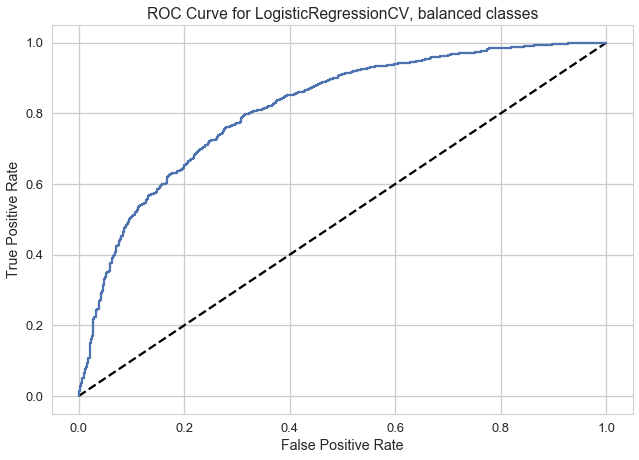

In [81]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg_clf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV, balanced classes')
plt.show()

In [82]:
# calculate AUC for LogisticRegressionCV classifier
metrics.roc_auc_score(y_test, y_pred_prob_logreg_clf)

0.8134012672298323

In [83]:
import eli5
eli5.show_weights(logreg_clf, vec=tfidf, top=20, target_names=y_test)

In [84]:
# view paramaters of logistic regression CV
logreg_clf

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [85]:
# test the current model
print(logreg_clf.predict(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[0 0]


In [86]:
# test the current model
print(logreg_clf.predict(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[0 1]


In [87]:
# test test without 'not' bigrams
print(logreg_clf.predict(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[0 0]


## Fit Support Vector Machines classifier

In [88]:
# try fitting with Support Vector Machines (SVM) algorithm with CountVectorizer (does not work with TFIDFVect)
clf_svm = SGDClassifier(max_iter=5, tol=None, alpha=0.1, random_state=42, class_weight='balanced').fit(X_train_dtm, y_train)
# parameters from GridSearch below
predicted_svm = clf_svm.predict(X_test_dtm)

metrics.f1_score(y_test, predicted_svm)

0.80779498131340111

In [89]:
# print the confusion matrix 
metrics.confusion_matrix(y_test, predicted_svm)

array([[ 654,  317],
       [ 403, 1513]])

In [90]:
# calculate AUC
metrics.roc_auc_score(y_test, predicted_svm)

0.73159920577757043

In [91]:
# get a list of the all available unique keys for the grid parameters
sorted(clf_svm.get_params().keys())

['alpha',
 'average',
 'class_weight',
 'epsilon',
 'eta0',
 'fit_intercept',
 'l1_ratio',
 'learning_rate',
 'loss',
 'max_iter',
 'n_iter',
 'n_jobs',
 'penalty',
 'power_t',
 'random_state',
 'shuffle',
 'tol',
 'verbose',
 'warm_start']

In [92]:
# apply GridSearchCV

# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {'alpha': (1, 0.1, 0.001, 0.0001)}

In [93]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_svm = GridSearchCV(SGDClassifier(max_iter=5, tol=None, random_state=42, class_weight='balanced'), parameters, n_jobs=-1)
gs_svm = gs_svm.fit(X_train_dtm, y_train)
# cannot set scoring to F1 or roc_auc

In [94]:
# View the best accuracy score
print('Best score for text:', gs_svm.best_score_) 

Best score for text: 0.746275551449


In [95]:
# View the best parameters
print('Best parameters:', gs_svm.best_params_) 
# Best parameters: {'alpha': 0.1}

Best parameters: {'alpha': 0.1}


In [96]:
# view the SVM parameters from grid search
clf_svm

SGDClassifier(alpha=0.1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [97]:
# test the current model
print(clf_svm.predict(tfidf.transform(['This book is not good. I do not recommend that you ever read it',
                                       'This book is not bad at all. I highly recommend this for anyone'])))

[0 0]


In [98]:
# test the current model
print(clf_svm.predict(tfidf.transform(['This is a big disappointing bore. I expected more. Unfortunately I was wrong',
                                       'This book awesome. You should totally read it'])))

[0 1]


In [99]:
# test test without 'not' bigrams
print(clf_svm.predict(tfidf.transform(['This book is bad. Avoid reading it',
                                       'This book is good. I highly recommend this for everyone'])))

[0 0]


### Can we improve parameterization of models with Pipelines?
#### Pipeline with CountVectorizer, TfidfTransformer, MultinomialNB classifier

In [100]:
# Can we do better with a pipeline?
# build pipeline with vectorizer, transformer, classifier
count_vec = CountVectorizer(ngram_range=(1,2))
tf_idf = TfidfTransformer()
clf_mnb = MultinomialNB()

steps = [('count_vec', count_vec),
         ('tf_idf', tf_idf),
         ('clf_mnb', clf_mnb)]

p_grid = [{'count_vec__min_df': [5,6,7]}]

pipeline = Pipeline(steps)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nb_gs = GridSearchCV(pipeline, param_grid=p_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

In [101]:
# view parameters of naive bayes pipeline and grid search
nb_gs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count_vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        ...r_tf=False, use_idf=True)), ('clf_mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'count_vec__min_df': [5, 6, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [102]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb_gs.get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__clf_mnb',
 'estimator__clf_mnb__alpha',
 'estimator__clf_mnb__class_prior',
 'estimator__clf_mnb__fit_prior',
 'estimator__count_vec',
 'estimator__count_vec__analyzer',
 'estimator__count_vec__binary',
 'estimator__count_vec__decode_error',
 'estimator__count_vec__dtype',
 'estimator__count_vec__encoding',
 'estimator__count_vec__input',
 'estimator__count_vec__lowercase',
 'estimator__count_vec__max_df',
 'estimator__count_vec__max_features',
 'estimator__count_vec__min_df',
 'estimator__count_vec__ngram_range',
 'estimator__count_vec__preprocessor',
 'estimator__count_vec__stop_words',
 'estimator__count_vec__strip_accents',
 'estimator__count_vec__token_pattern',
 'estimator__count_vec__tokenizer',
 'estimator__count_vec__vocabulary',
 'estimator__memory',
 'estimator__steps',
 'estimator__tf_idf',
 'estimator__tf_idf__norm',
 'estimator__tf_idf__smooth_idf',
 'estimator__tf_idf__sublinear_tf',
 'estimator__tf_idf__use_idf',
 'fit_p

In [103]:
# Fitting the Naive Bayes model 
nb_gs.fit(X_train, y_train)
y_pred = nb_gs.best_estimator_.predict(X_test)

# View the best score (set to roc_auc) for MultinomialNB with GridSearch
print('Best score for text:', nb_gs.best_score_) 

# View the best parameters
print('Best parameters:', nb_gs.best_params_) 

Best score for text: 0.789807749135
Best parameters: {'count_vec__min_df': 5}


#### Pipeline with CountVectorizer, TfidfTransformer, SVC classifier

In [104]:
# Build pipeline with Support Vector Machines SVC classifier
count_vec = CountVectorizer()
tf_idf = TfidfTransformer()
clf_SVC = SVC(class_weight='balanced')

steps = [('count_vec', count_vec),
         ('tf_idf', tf_idf),
         ('clf_SVC', clf_SVC)]

p_grid = [{'count_vec__min_df': [4,5,6],
           'clf_SVC__random_state': [42],
           #'clf_SVC__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
           #'clf_SVC__C': [0.1,1,10,100,1000],
           #'clf_SVC__gamma': [0.1,1,10,100,1000]
          }]

pipeline = Pipeline(steps)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_gs = GridSearchCV(pipeline, param_grid=p_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

In [105]:
# Fitting the SVM model 
svm_gs.fit(X_train, y_train)
y_pred_svm = svm_gs.best_estimator_.predict(X_test)

In [106]:
# View the best score (set to roc_auc) for SVC with GridSearch
print('Best score for text:', svm_gs.best_score_) 

# View the best parameters
print('Best parameters:', svm_gs.best_params_) 

Best score for text: 0.770146635216
Best parameters: {'clf_SVC__random_state': 42, 'count_vec__min_df': 4}


#### Pipeline with CountVectorizer, TfidfTransformer, Random Forest classifier

In [110]:
# Testing the Random Forest Classifier on review data 
clf_RFC = RandomForestClassifier()

steps = [('counts', CountVectorizer(min_df=1)),
         ('tf_idf', TfidfTransformer()),
         ('clf_RFC', RandomForestClassifier(random_state=42, class_weight='balanced'))]

pipeline = Pipeline(steps)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
p_grid = [{'counts__min_df': [1,3,5],
           'clf_RFC__n_estimators': [500,600,700], 
           #'clf_RFC__min_samples_leaf': range(1,30),
           #'clf_RFC__min_samples_split': range(2,30)
          }]

rf_gs = GridSearchCV(pipeline, param_grid=p_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

In [111]:
# view random forest grid search parameters
rf_gs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        str...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'counts__min_df': [1, 3, 5], 'clf_RFC__n_estimators': [500, 600, 700]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [112]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(rf_gs.get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__clf_RFC',
 'estimator__clf_RFC__bootstrap',
 'estimator__clf_RFC__class_weight',
 'estimator__clf_RFC__criterion',
 'estimator__clf_RFC__max_depth',
 'estimator__clf_RFC__max_features',
 'estimator__clf_RFC__max_leaf_nodes',
 'estimator__clf_RFC__min_impurity_decrease',
 'estimator__clf_RFC__min_impurity_split',
 'estimator__clf_RFC__min_samples_leaf',
 'estimator__clf_RFC__min_samples_split',
 'estimator__clf_RFC__min_weight_fraction_leaf',
 'estimator__clf_RFC__n_estimators',
 'estimator__clf_RFC__n_jobs',
 'estimator__clf_RFC__oob_score',
 'estimator__clf_RFC__random_state',
 'estimator__clf_RFC__verbose',
 'estimator__clf_RFC__warm_start',
 'estimator__counts',
 'estimator__counts__analyzer',
 'estimator__counts__binary',
 'estimator__counts__decode_error',
 'estimator__counts__dtype',
 'estimator__counts__encoding',
 'estimator__counts__input',
 'estimator__counts__lowercase',
 'estimator__counts__max_df',
 'estimator__counts__max_

In [113]:
# Fitting the Random Forest Classifier model
rf_gs.fit(X_train, y_train)
y_pred_rf = rf_gs.best_estimator_.predict(X_test)

In [114]:
# View the best score (set to roc_auc) for MultinomialNB with GridSearch
print('Best roc_aucscore for rf model:', rf_gs.best_score_) 

# View the best parameters
print('Best pipeline parameters:', rf_gs.best_params_)
# took a long time to run: Best roc_aucscore for rf model: 0.784793252035
#Best pipeline parameters: {'clf_RFC__n_estimators': 600, 'counts__min_df': 3}

Best roc_aucscore for rf model: 0.79220580241
Best pipeline parameters: {'clf_RFC__n_estimators': 700, 'counts__min_df': 3}
